In [149]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [69]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [70]:
crime = crime.groupby('date').agg(count=('precinct','count')).reset_index()
crime = crime.set_index('date')
crime.index = pd.to_datetime(crime.index)

# Monthly seasonality

In [238]:
monthly = crime.resample('W').sum()

## Calculate stationarity
- Using ADFuller test

ADF Statistic: -3.086913201981612
p-value: 0.027536951341060923
Critical Values:
	1%: -3.4410802944179686
	5%: -2.8662741915097736
	10%: -2.569291225276603


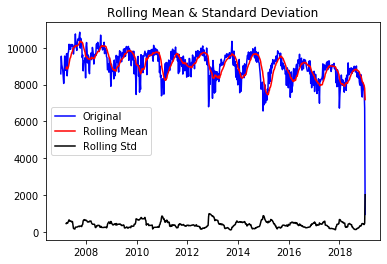

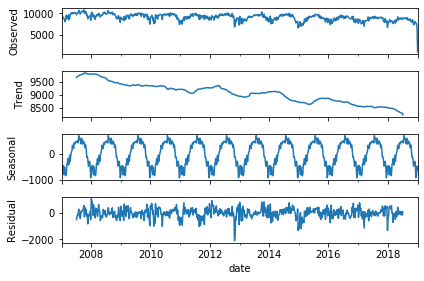

In [239]:
def get_stationarity(timeseries, window=12):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries)
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(monthly)

- there is a strong seasonal component which is good!
- but there is also a trend :(

## Detrend by Differencing
- Perhaps the simplest method to detrend a time series is by differencing. Specifically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

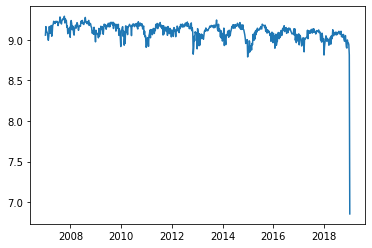

In [240]:
df_log = np.log(monthly)
plt.plot(df_log)

ADF Statistic: -3.2700670295258023
p-value: 0.016270661972553092
Critical Values:
	1%: -3.4410451945636207
	5%: -2.8662587328558566
	10%: -2.569282988466721


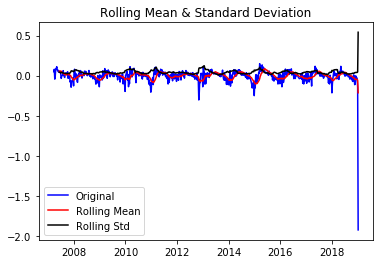

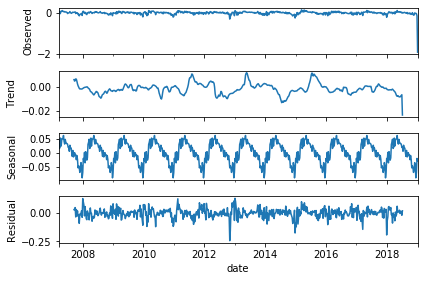

In [241]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

ADF Statistic: -2.0856077533768107
p-value: 0.25034103719971945
Critical Values:
	1%: -3.440856177517568
	5%: -2.86617548304384
	10%: -2.56923863104


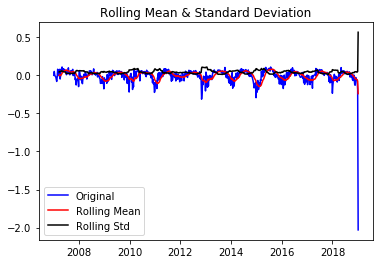

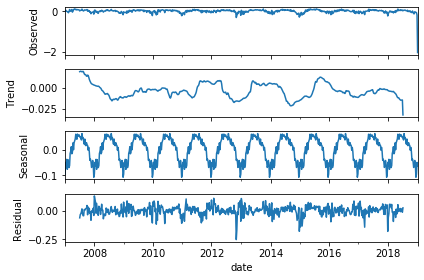

In [242]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

ADF Statistic: -21.253475203186643
p-value: 0.0
Critical Values:
	1%: -3.440856177517568
	5%: -2.86617548304384
	10%: -2.56923863104


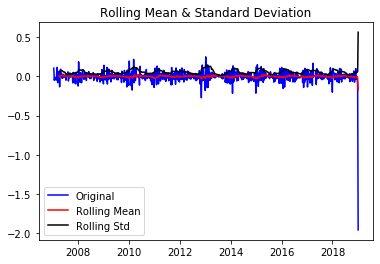

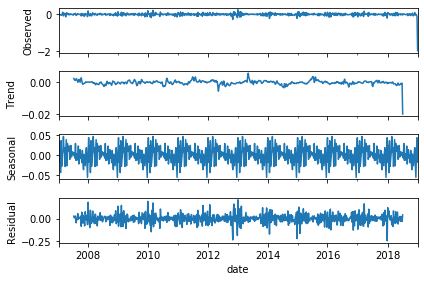

In [243]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

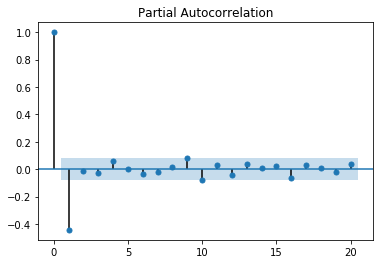

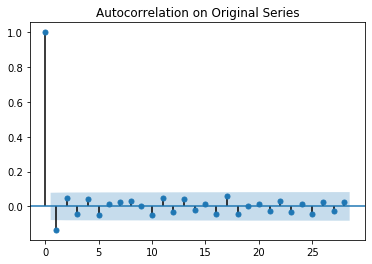

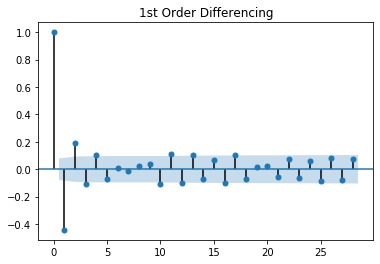

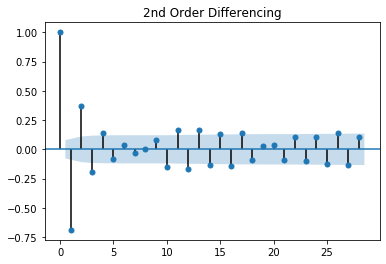

In [244]:
def auto_correlation(timeseries):

    fig = plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    
    fig = plot_acf(timeseries, title="Autocorrelation on Original Series") 
    fig = plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")
    fig = plot_acf(timeseries.diff().diff().dropna(), title="2nd Order Differencing")
    
auto_correlation(df_log_shift)

C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


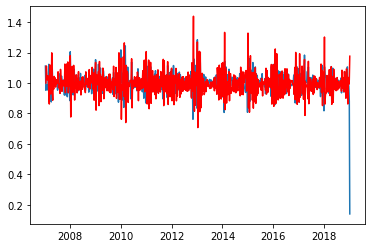

In [252]:
model = ARIMA(df_log, order=(2,2,2))
results = model.fit(disp=-1)
plt.plot(np.exp(df_log_shift))
plt.plot(np.exp(results.fittedvalues), color='red')

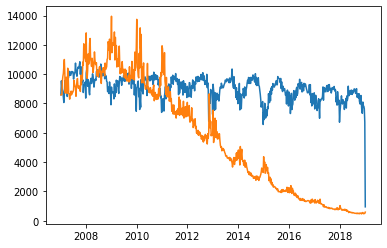

In [246]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['count'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(monthly)
plt.plot(predictions_ARIMA)

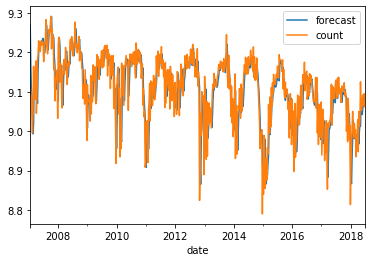

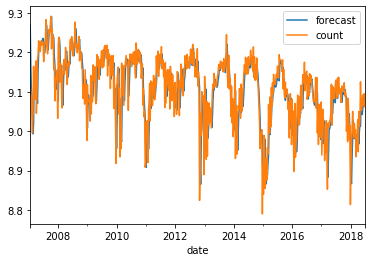

In [248]:
results.plot_predict(2,599)

In [249]:
results.summary()

C:\Users\Zaca\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Zaca\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Zaca\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Zaca\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                  625
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 575.531
Method:                       css-mle   S.D. of innovations              0.096
Date:                Sat, 14 Mar 2020   AIC                          -1139.061
Time:                        13:21:40   BIC                          -1112.435
Sample:                    01-21-2007   HQIC                         -1128.715
                         - 01-06-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.708e-05   1.63e-05     -1.663      0.097    -5.9e-05    4.84e-06
ar.L1.D2.count    -1.2495        nan        nan        nan         nan         nan
ar.L2.D2.count    -0.3183        nan        nan        nan         nan         nan
ma.L1.D2.count    -0.1129        nan        nan        nan         nan         nan
ma.L2.D2.count    -0.8850        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1196           +0.0000j            1.1196            0.5000
AR.2           -2.8064           +0.0000j            2.8064            0.5000
MA.1            1.0011           +0.0000j            1.0011            0.0000
MA.2           -1.1287           +0.0000j            1.1287            0.5000
-----------------------------------------------------------------------------
"""

ADF Statistic: -5.910312080113374
p-value: 2.6484047257895957e-07
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


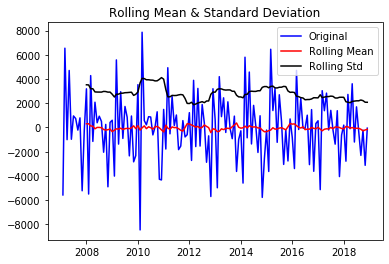

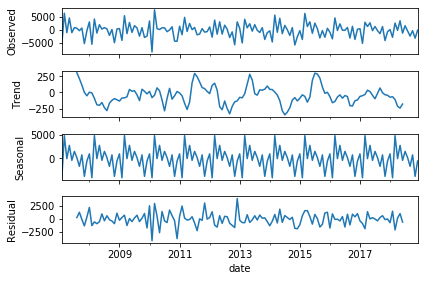

In [201]:
monthly_shift = monthly - monthly.shift()
monthly_shift.dropna(inplace=True)
get_stationarity(monthly_shift)

In [202]:
# Subtracting the rolling mean

ADF Statistic: -3.789474496415411
p-value: 0.0030168592650616217
Critical Values:
	1%: -3.486055829282407
	5%: -2.8859430324074076
	10%: -2.5797850694444446


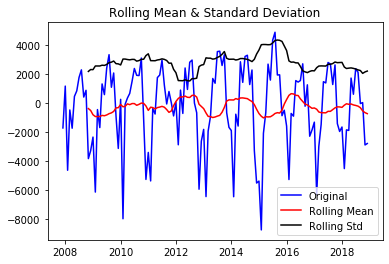

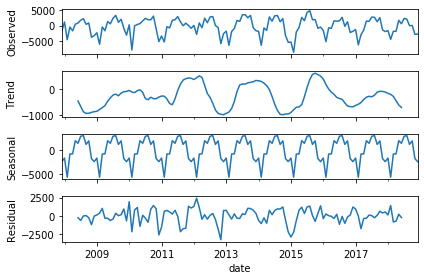

In [203]:
rolling_mean = monthly.rolling(window=12).mean()
monthly_minus_mean = monthly - rolling_mean
monthly_minus_mean.dropna(inplace=True)
get_stationarity(monthly_minus_mean)

Partial Auto Correlation Function (PACF)
As the name implies, PACF is a subset of ACF. PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We can use PACF to determine the optimal number of terms to use in the AR model. The number of terms determines the order of the model.

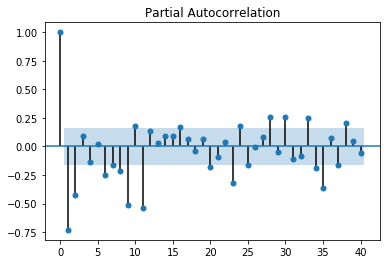

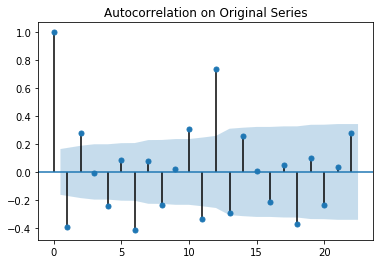

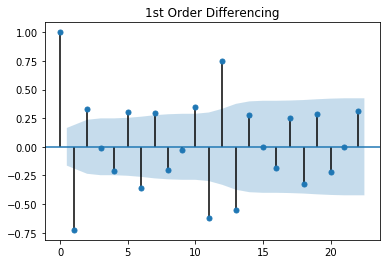

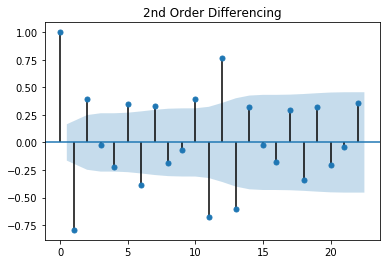

# ARIMA

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [187]:
def model_arima(timeseries, p, d, q):
    
    model = ARIMA(arima, order=(p,d,q))
    results = model.fit(disp=0)
    results.plot_predict(4, 240)
    results.summary()

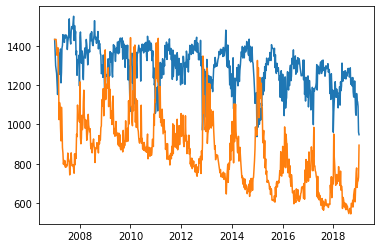

In [57]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(arima_log['count'].iloc[0], index=arima_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(arima)
plt.plot(predictions_ARIMA)

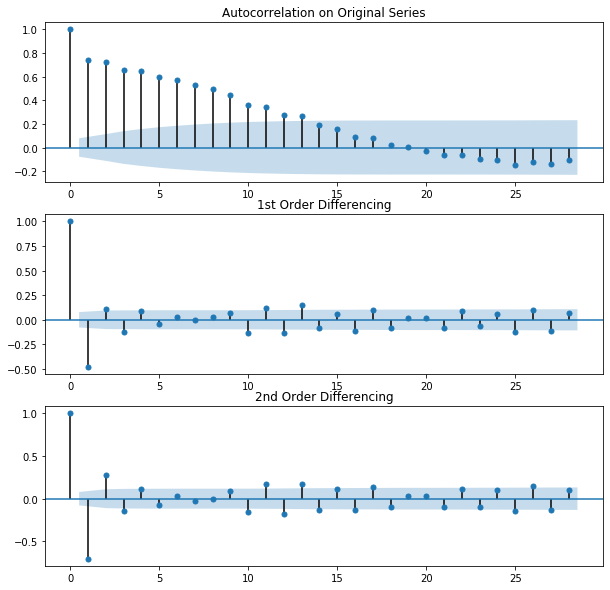

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(arima_log, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(arima_log.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(arima_log.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

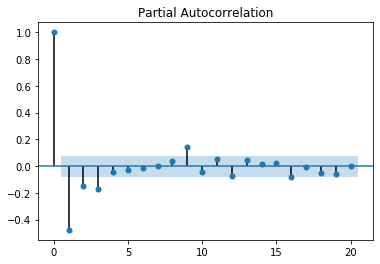

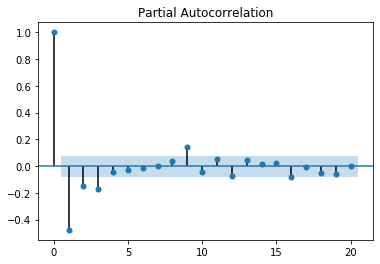

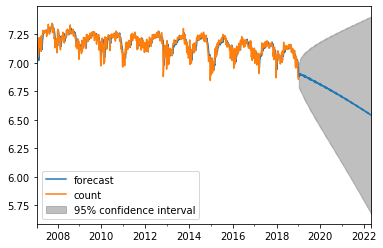

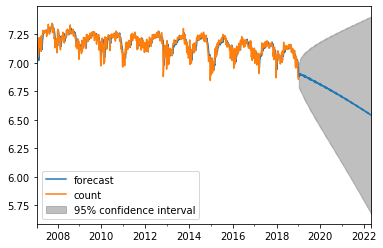

In [55]:
results.plot_predict(2,800)